# $\mathbf{CHURN}$ $\mathbf{DRIVERS}$ $\mathbf{AND}$ $\mathbf{PREDICTION}$ $\mathbf{REPORT}$
###  Prepared for Dirk Digglerholmsteingrensonowski, COO, Telco Intergalatic
$\rightarrow$Report and Presentation by Ryan Miller, Staff Data Scientist | 5/25/2022

----

# $\blacksquare$ Executive Summary

- ### Problem:  
### The operations team reached out to the data science division to understand what the main drivers of customer churn are, and to predict future churn based on these drivers in order for ops and marketing to intercede before we lose these customers.
- ### Actions:
### Performed an analysis examing drivers of churn using statistical testing, as well as creating and examing a number of models to predict churn to see what levers we have for retaining customers.  26.5% of customers churn in the month examined costing \$2.4MM.
- ### Conclusions:  
### Customers without dependents, streaming services and not subscribing to auxiliary services are driving churn.  In general, those with higher monthly costs are also more prone to churn - and quickly.  Fortunately, we now have a model that predicts churn nearly 9\% better than baseline, so we can better target those customers with churn reducing interventions.
- ### Recommendations: 
### Allow customers without dependents to join "friends and family plans" akin to having dependents, and analyze streaming service prices to evaluate their cost vs. percevied value, and perhaps give a few months fo those services at a free or reduced cost.

# $\blacksquare$ Libraries Used

#### The following libraries and tools are used in the following report:

Common DS Libraries:

In [1]:
# For data analysis:
import numpy as np
import pandas as pd

# Graphs/Visualizations:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# For Statistics and Hypothesis Testing:
import scipy.stats as stats

# For Modeling:
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

Internally Created Helper Functions:

In [2]:
# For acquiring data (note - your credentials will work if stored in an env.py file):
from acquire import get_telco_data

# For preparing/'cleaning' the dataset:
from prepare import prep_telco

# For splitting the dataset into Train, Validate and Test sets:
from splitter import splitter

# For displaying evaluation metrics
from matrix_result import matrix_result_2d

Others:

In [3]:
#Ignore Warnings:
import warnings
warnings.filterwarnings('ignore')

# $\blacksquare$ Data Acquisition and Summary Analysis

### Data is a snapshot of our customers from January of this year.  It is found in the CodeUp DB Server 'telco_churn' database.
Data was first SQL queried in MySQLWorkbench then aquired.

In [4]:
# Acquire dataset into dataframe
df_raw = get_telco_data()

A quick glance of the data:

In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   customer_id               7043 non-null   object 
 3   contract_type_id          7043 non-null   int64  
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

Upon examination, the total_charges variable is an object, meaning string.  Upon further investigation there were 11 records that were empty strings; those same 11 had zero tenure, so those customers dropped before even paying.
- **As such, in the prep phase, these are removed.**

### A cursory dive into the data was performed to generate some general theses.  This included examining every categorical variable against our target variable, churn, and getting descriptive stats on these features.  Outliers and other funky data were of particular interest.  Details can be found in 'telco_workbook.ipynb'.

## The following are some key questions and takeaways from this ***Univariate Analysis***:

### *What is the percentage of churn of Telco customers?*

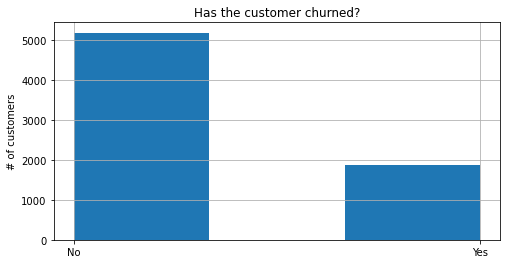

In [6]:
# Draw simple histogram of churn vs. non-churned customers
plt.figure(figsize = (8,4))
df_raw.churn.hist(bins=3, align='mid')
plt.title('Has the customer churned?')
plt.ylabel('# of customers')
plt.show()
churn_count = df_raw[df_raw.churn == 'Yes'].churn.count()

In [7]:
print(f'Pecentage of customers who churn: {100*(churn_count/df_raw.churn.count()):.1f}%')

Pecentage of customers who churn: 26.5%


### *What do monthly chages look like across all customers?*

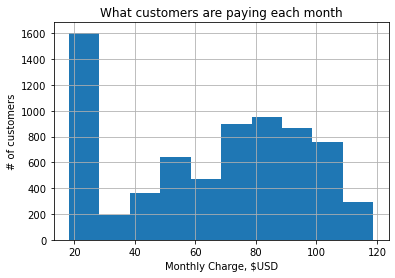

In [8]:
# Histogram of monthly charges
df_raw.monthly_charges.hist()
plt.title('What customers are paying each month')
plt.ylabel('# of customers')
plt.xlabel('Monthly Charge, $USD')
plt.show()

The distribution of monthly charges is interesting - a plurality of customers are paying  between \\$20 and \\$30, the remainder have a normal distribution centered between \\$80 and \\$90.

### *Other questions from the examination:*
- How does churn relate to the monthly charges?  Do higher monthly charges drive more churn?
- There is a 2:1 ratio of customers reporting dependants to those who don't.  Is there a difference in churn between these two groups?
- Does having certain monthly services affect churn (such as online_security, online_backup, device_protection, tech_support, streaming_tv, and streaming_movies)?
- Which features are statistically irrelevant to churn?

# $\blacksquare$ Data Preparation

### Based on the *Summary Data Analysis* above, the following data prep plan was executed:
- Remove the 11 zero-tenure month records
- Drop customer_id
- Drop all \_id categories (covered by actual categories which are just as wasy to encode)
- Drop signup date (since all churn dates = 1/2022, all tenure captures this information)
- Convert all yes/no to 1/0
- Convert total charges to float
- *The categorical variables were also encoded to use later*

In [9]:
# Prep/clean dataset
df = prep_telco(df_raw)

### Splitting the dataset into Train-Validate-Test subsets, using 'churn' to stratify:

In [10]:
df_train, df_validate, df_test = splitter(df, target = 'churn')

Train = 56.0% | Validate = 24.0% | Test = 20.0%


# $\blacksquare$ Exploratory Data Analysis

## Bivariate Analysis

*Note: Analysis of every categorical's affect on churn can be found in the associated workbook.

### *Question: How does churn relate to the monthly charges?  Do higher monthly charges drive more churn?*

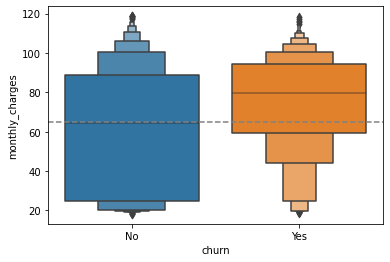

In [11]:
# Boxplot comparing churn and monthly charges and showing mean monthly charge
sns.boxenplot(data=df_train, x='churn',y='monthly_charges')
plt.axhline(df_train['monthly_charges'].mean(), ls='--', color='gray')
plt.show()

#### While it looks like higher monthly charged lead to greater churn, using t-tests to compare the means will concretly determine if there is a difference between churning and not churning based on the mean of the monthly charge.

Verification of assumptions to use t-test:

In [12]:
# Split into churn vs non-churn samples and test for equal variances
train_churn_sample = df_train[df_train.churn == 'Yes']
train_nochurn_sample = df_train[df_train.churn == 'No']
train_churn_sample.monthly_charges.var(), train_nochurn_sample.monthly_charges.var()

(604.8633241695393, 982.7932072180829)

*Set equal_var to 'False', independence and normal distribution assumptions met.*

Formulate test hypothesis:

- The null hypothesis, H$\scriptsize 0$ = The mean monthly charges of churned customers is less than or equal to non-churned customers.
- The alternative hypothesis, H$\scriptsize a$ = The mean monthly charges of churned customers is greater than non-churned customers.

In [13]:
# Set alpha for a confidence interval of 95%
alpha = .05

One sided t-test comparing churn vs non-churned means:

In [14]:
t_1, p_1 = stats.ttest_ind(train_churn_sample.monthly_charges, train_nochurn_sample.monthly_charges, equal_var=False)
if (p_1/2) < alpha:
    print(f'p = {p_1/2}; Thus, we reject the null hypothesis that the mean monthly charges of churned customers is less than or equal to all customers.')
else: print(f'p = {p_1/2}, Thus, we fail to reject the null hypothesis that the mean monthly charges of churned customers is less than or equal to all customers.')

p = 1.230065388468921e-43; Thus, we reject the null hypothesis that the mean monthly charges of churned customers is less than or equal to all customers.


In [15]:
t_1

14.089590985741236

#### Since we reject the null hypothesis, and t > 0, churned customers do pay more monthly than non-churned customers.

### *Question: Is there a difference in churn between those with dependents (families) and those without?*

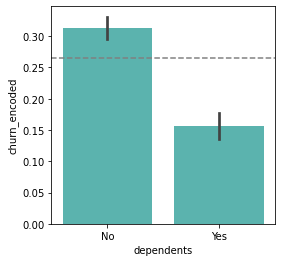

In [16]:
# Plot customers with dependent vs those without vs. percent that churn and overall churn average.
plt.figure(figsize=(4,4))
sns.barplot(x = 'dependents', y = 'churn_encoded', data=df_train, alpha=.8, color='lightseagreen')
plt.axhline(df_train['churn_encoded'].mean(), ls='--', color='gray')
plt.show()

#### This is pretty clear that having dependents decreases churn, but to make sure a Chi-Squared test was performed.

- The null hypothesis, H$\scriptsize 0$ = There is no relationship between dependent status and churn.
- The alternative hypothesis, H$\scriptsize a$ = There is a relationship between dependent status and churn.

In [17]:
# Chi-squared test for independence, with alpha of .05
alpha = .05
observed_dependents = pd.crosstab(df_train['dependents'], df_train['churn'])
chi2_dep, p_dep, degf_dep, expected_dep = stats.chi2_contingency(observed_dependents)
if p_dep < alpha:
    print(f'p = {p_dep}; Thus, we reject the null hypothesis that there is no relationship between dependent status and churn.')
else: print(f'p = {p_dep}; Thus, we fail to reject the null hypothesis that there is no relationship between dependent status and churn.')

p = 1.5385742575781703e-24; Thus, we reject the null hypothesis that there is no relationship between dependent status and churn.


#### Therefore, having dependents results in a lower rate of churn.

### *Question: Does having certain monthly services affect churn (such as Online Security, Online Backup, Device Protection, Tech Support, Streaming TV, and Streaming Movies)*

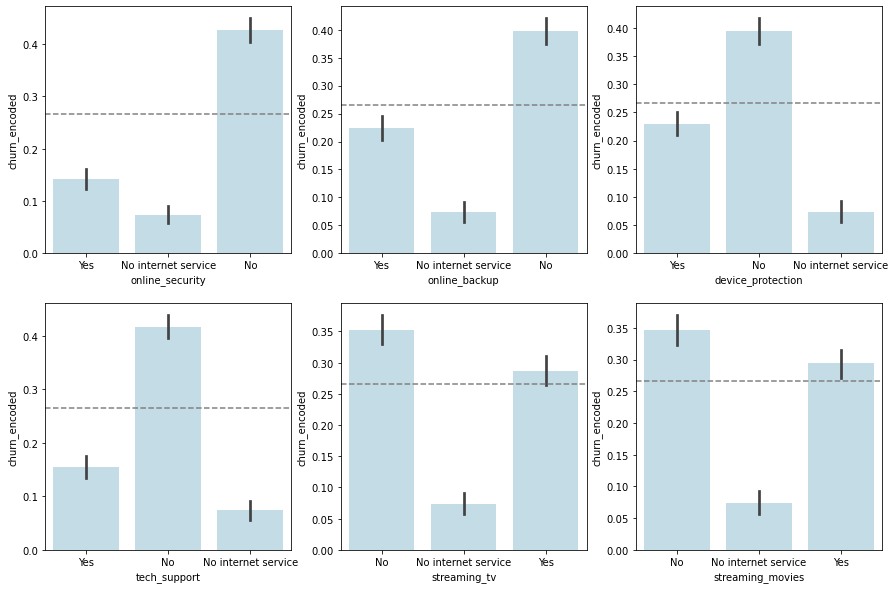

In [18]:
# Plots of key internet services vs. percent who churn, along with average churn percentage
feature_columns = ['online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
plt.figure(figsize=(15,10))
i=1
for col in feature_columns:
    plt.subplot(2, 3, i)
    sns.barplot(x = col, y = 'churn_encoded', data=df_train, alpha=.8, color='lightblue')
    plt.axhline(df_train['churn_encoded'].mean(), ls='--', color='gray')
    i+=1
plt.show()

#### Most internet services reduce churn - meaning customers likely feel they are valuable for what they are paying for them.  Streaming services, on the other hand, increase churn.  My guess is streaming comes with Fiber Optic, which was identified in a previous study to be a driver of churn.

### *Question: Which features are statistically irrelevant to churn?*

Based on initial analysis, gender and phone service to not imapct customer churn.

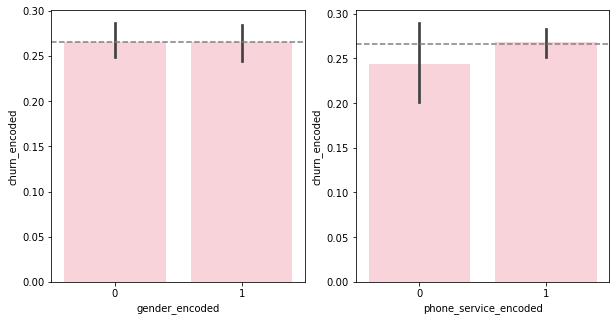

In [19]:
# Plot irrelevant features to churn; these features also failed to reject null in Chi-squared found in working notebook.
irrelevant_features = ['gender_encoded', 'phone_service_encoded']
plt.figure(figsize=(10,5))
plt.subplot(121)
sns.barplot(x = irrelevant_features[0], y = 'churn_encoded', data=df_train, alpha=.8, color='pink')
plt.axhline(df_train['churn_encoded'].mean(), ls='--', color='gray')
plt.subplot(122)
sns.barplot(x = irrelevant_features[1], y = 'churn_encoded', data=df_train, alpha=.8, color='pink')
plt.axhline(df_train['churn_encoded'].mean(), ls='--', color='gray')
plt.show()

#### Gender and phone service should be dropped from the model, as they do not impact churn.

## Multivariate Analysis

### *Building on the question around churn rate and monthly charges:*

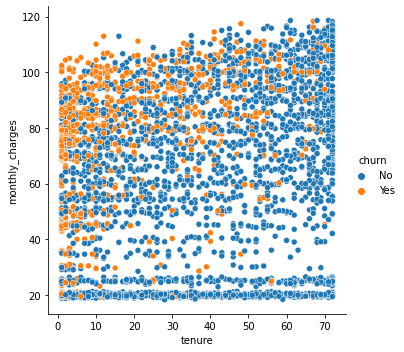

In [20]:
# Plot illustrating both time and monthly charges of churn.
sns.relplot(data=df_train, x='tenure', y='monthly_charges', hue='churn')
plt.show()

#### Churn not only happens with higher monthly costs, but typically happens fast.

### Analysis Key Takeaways:
1. #### Higher monthly costs means higher churn.
2. #### Families churn less than individuals.
3. #### Auxilliary internet services decrease churn, but streaming services increase it.
4. #### A customers gender and whether they have phone service or not does not impact churn.

# $\blacksquare$ Classification Modeling

### Dropping extraneous features 

In [21]:
df_train = df_train.drop(columns=irrelevant_features)
df_validate = df_validate.drop(columns=irrelevant_features)
df_test = df_test.drop(columns=irrelevant_features)

In addition to dropping all features not relevant for modeling, to perform classification non-numeric variables except for our target are dropped.  In addition, we split each sample into target and non-target sets.

In [22]:
# Drop non-numeric (encoded) columns and then seperate samples into target and non-target sets for modeling
columns_to_drop = ['customer_id','gender', 'partner', 'dependents',
       'phone_service', 'multiple_lines', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'paperless_billing', 'contract_type', 'internet_service_type', 'payment_type','churn_encoded']
df_train_encoded = df_train.drop(columns=columns_to_drop)
df_validate_encoded = df_validate.drop(columns=columns_to_drop)
df_test_encoded = df_test.drop(columns=columns_to_drop)

X_train = df_train_encoded.drop(columns=["churn"])
y_train = df_train_encoded.churn

X_validate = df_validate_encoded.drop(columns=["churn"])
y_validate = df_validate_encoded.churn

X_test = df_test_encoded.drop(columns=["churn"])
y_test = df_test_encoded.churn

### Baseline Case

#### For the Baseline Case, it is assumed a customer does NOT CHURN, as it is the most frequent occurance.  With the baseline case we have the following:

In [23]:
# Calculate baseline accuracy pecentage
baseline = y_train.mode()
matches_baseline_prediction = (y_train == baseline.values[0])
baseline_accuracy = matches_baseline_prediction.mean()
print(f"Baseline accuracy: {round(baseline_accuracy, 2)}")

Baseline accuracy: 0.73


##### Any model having less than 73% accuracy should be disregarded.

### The training (in-sample) data was fit to the following four classification models, and examined against the baseline case:
- Decision Tree
- Random Forest
- K-Nearest Neighbors
- Logistical Regression
### The target variable is churn with the positive case being 'Not Churned'.  Each test was run with with a number of tuned hyperparameters, and all tests can be found in supporting workbook.  
### In addition to accuracy, the most important evaluation metric analyzed was **False Positive** that means that we predict the customer does not churn when in fact they do churn, as the cost of churn is likley higher than the mitigating actions we will take against it happening.  Thus, we maximize for Precision.

## Validation of Best Models

In [24]:
# Create a list to be converted into dataframe for easy model results comparison
model_comparator = []

##### The following model/hyperparameter combinations which best met the evaluation metric criteria were then tested for overfitting using the validation set:

### Decision Tree, Depth = 4

In [25]:
# Valditing decision tree model with selected hyperparameters on out-of-sample data
tree = DecisionTreeClassifier(max_depth=4, random_state=123)
tree = tree.fit(X_train, y_train)
y_tree_pred = tree.predict(X_validate)
result = pd.DataFrame(confusion_matrix(y_validate, y_tree_pred))
results = matrix_result_2d(result)
results['model'] = 'Decision Tree, Depth = 4'
model_comparator.append(results)
matrix_result_2d(result, output='print')

True Positive = 1093
False Positive = 230
True Negative = 219
False Negative = 146
Precision = 0.83
Recall = 0.88
Accuracy = 0.78
F1 Score = 0.85
Support, Positive = 1239
Support, Negative = 449


### Random Forest, Depth = 7, Leaves = 6

In [26]:
# Valditing random forest model with selected hyperparameters on out-of-sample data
forest = RandomForestClassifier(max_depth=7, min_samples_leaf = 6,random_state=123)
forest = forest.fit(X_train, y_train)
y_forest_pred = forest.predict(X_validate)
result = pd.DataFrame(confusion_matrix(y_validate, y_forest_pred))
results = matrix_result_2d(result)
results['model'] = 'Random Forest, Depth = 7, Leaves = 4'
model_comparator.append(results)
matrix_result_2d(result, output='print')

True Positive = 1108
False Positive = 215
True Negative = 234
False Negative = 131
Precision = 0.84
Recall = 0.89
Accuracy = 0.80
F1 Score = 0.86
Support, Positive = 1239
Support, Negative = 449


### K-Nearest Neighbors, Neighbors = 15

In [27]:
# Valditing KNN model with selected hyperparameters on out-of-sample data
knn = KNeighborsClassifier(n_neighbors = 15)
knn = knn.fit(X_train, y_train)
y_knn_pred = knn.predict(X_validate)
result = pd.DataFrame(confusion_matrix(y_validate, y_knn_pred))
results = matrix_result_2d(result)
results['model'] = 'KNN, Neighbors = 15'
model_comparator.append(results)
matrix_result_2d(result, output='print')

True Positive = 1132
False Positive = 267
True Negative = 182
False Negative = 107
Precision = 0.81
Recall = 0.91
Accuracy = 0.78
F1 Score = 0.86
Support, Positive = 1239
Support, Negative = 449


### Logistical Regression, Default

In [28]:
# Valditing loistical regression model on out-of-sample data
logit = LogisticRegression()
logit = logit.fit(X_train, y_train)
y_logit_pred = logit.predict(X_validate)
result = pd.DataFrame(confusion_matrix(y_validate, y_logit_pred))
results = matrix_result_2d(result)
results['model'] = 'Logistical Regression, Default'
model_comparator.append(results)
matrix_result_2d(result, output='print')

True Positive = 1103
False Positive = 206
True Negative = 243
False Negative = 136
Precision = 0.84
Recall = 0.89
Accuracy = 0.80
F1 Score = 0.87
Support, Positive = 1239
Support, Negative = 449


In [29]:
# Create dataframe to select final model to apply to test data
df_results = pd.DataFrame(model_comparator).round(2).set_index('model')
df_results

,true_positive,false_positive,true_negative,false_negative,precision,recall,accuracy,f1_score,support_pos,support_neg
model,,,,,,,,,,
"Decision Tree, Depth = 4",1093,230,219,146,0.83,0.88,0.78,0.85,1239,449
"Random Forest, Depth = 7, Leaves = 4",1108,215,234,131,0.84,0.89,0.80,0.86,1239,449
"KNN, Neighbors = 15",1132,267,182,107,0.81,0.91,0.78,0.86,1239,449
"Logistical Regression, Default",1103,206,243,136,0.84,0.89,0.80,0.87,1239,449


In [30]:
print(f'Model impovement over baseline = {((.8-baseline_accuracy)/baseline_accuracy):.3f}')

Model impovement over baseline = 0.089


### *Random forest has the best precision as well as an accuracy of 80% - which is 9% better than baseline*

## Test Best Model (Random Forest)

In [31]:
# Test best model on new data
y_forest_pred = forest.predict(X_test)
result = pd.DataFrame(confusion_matrix(y_test, y_forest_pred))
matrix_result_2d(result, output='print')

# Generate predictions CSV File - much of the code courtesy of Faith Kane:
y_forest_proba = forest.predict_proba(X_test)
proba_df = pd.DataFrame(y_forest_proba, columns=forest.classes_.tolist()).round(4)
proba_df = proba_df.rename(columns={'No':'Not Churned','Yes':'Churned'})
reset_test = df_test.reset_index()
test_proba_df = pd.concat([reset_test, proba_df], axis=1)
y_forest_pred = np.where(y_forest_pred == 'No', 'Not Churned', 'Churned')
test_proba_df['predicted'] = y_forest_pred
csv_df = test_proba_df[['customer_id', 'Not Churned', 'Churned', 'predicted']]
csv_df.to_csv('predictions.csv')

True Positive = 927
False Positive = 167
True Negative = 207
False Negative = 106
Precision = 0.85
Recall = 0.90
Accuracy = 0.81
F1 Score = 0.87
Support, Positive = 1033
Support, Negative = 374


# $\blacksquare$ Conclusion

### Churn Drivers
- #### In general, higher cost = higher churn.
- #### Not having dependents
- #### Having streaming services
- #### Not having auxilliary internet services

### Modeling Effectiveness
- #### The baseline model, which assumes no one churns, is 73% accurate
- #### Classification model needs to bother be better than 73% accurate and should optimize for Precision (we would rather assume someone churned then miss them churning)
- #### Our best model predicted churn with 85% precision and 81% accuracy on new data (see predictions.csv)

### Recommendations
- #### Allow individual customers (those without depedents) to join "Friends & Family" plans
- #### Evaluate streaming services cost vs. perceived value to customer, if price is a factor, give a few months of these services for free.

### Future Analysis recommendations:
- #### Include the price of individual added internet services and streaming to determine how they effect monthly charges vs. perceived value, and use those as retention levers.
- #### Test logical regression with a number of hyperparameters.
- #### Determine if auxilliary internet services are not indepedent with other variables, for example maybe those with dependents have more of these services and it is not the services themselves that are driving the decreased churn.
- *From a project standpoint, learn some more formatting to make these presentations clearer*